In [1]:
from __future__ import print_function, division

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import LogFormatterMathtext, \
                              LogLocator
import seaborn as sns
sns.set(context="poster")

from IPython.display import display, Math
from ipywidgets import interactive, RadioButtons

import numpy as np
import pandas as pd

from astropy.modeling import models, fitting

## Boilerplate path hack to give access to full SNe package
import sys, os
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))

from SNe.analysis.constants import m_proton, metallicity_solar
from SNe.analysis.parse import parse_run, RunSummary
from SNe.analysis.parameter_study_file_structure import make_dirname_from_properties

/Users/egentry/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
background_temperature = 1e4

background_densities = 1.33 * m_proton * 10**np.array([ 0,
                                                        1,
                                                        2,
                                                        3,
                                                       -1,
                                                       -2,
                                                       -3], dtype=float)

metallicities = metallicity_solar * 10**np.array([ 0.0, 
                                                   0.5,
                                                  -0.5,
                                                  -1.0,
                                                  -1.5,
                                                  -2.0,
                                                  -3.0], dtype=float)
background_densities.sort()
metallicities.sort()

columns = ["background_density", "background_temperature", "metallicity",
           "number_density",
           "E_R_kin", "E_R_int", "E_R_tot", "t_f", "R_shock"]

df = pd.DataFrame(index=[0], columns=columns)
df = df[0:0]
with_cooling = True
i = 0
for background_density in background_densities:
    for metallicity in metallicities:
        print()
        print("metallicity: ", metallicity)
        print("background density:", background_density)
        data_dir = make_dirname_from_properties(background_density,
                                                metallicity,
                                                background_temperature,
                                                with_cooling)
        last_run = RunSummary()
        parse_results = parse_run(data_dir=data_dir, id="", last_run=last_run)
        cooling_index = np.argmin(np.abs(last_run.times - last_run.t_f))
        print("cooling index: ", cooling_index)
        
        df.loc[i] = [background_density, background_temperature, metallicity,
                     background_density / m_proton,
                     last_run.E_R_kin[cooling_index], 
                     last_run.E_R_int[cooling_index], 
                     last_run.E_R_tot[cooling_index], 
                     last_run.t_f,
                     last_run.R_shock[cooling_index]]
        i += 1
        
        
        


metallicity:  2e-05
background density: 2.22458726e-27
cooling index:  35

metallicity:  0.0002
background density: 2.22458726e-27
cooling index:  35

metallicity:  0.000632455532034
background density: 2.22458726e-27
cooling index:  35

metallicity:  0.002
background density: 2.22458726e-27
cooling index:  35

metallicity:  0.00632455532034
background density: 2.22458726e-27
cooling index:  35

metallicity:  0.02
background density: 2.22458726e-27
cooling index:  34

metallicity:  0.0632455532034
background density: 2.22458726e-27
cooling index:  33

metallicity:  2e-05
background density: 2.22458726e-26
cooling index:  35

metallicity:  0.0002
background density: 2.22458726e-26
cooling index:  35

metallicity:  0.000632455532034
background density: 2.22458726e-26
cooling index:  36

metallicity:  0.002
background density: 2.22458726e-26
cooling index:  35

metallicity:  0.00632455532034
background density: 2.22458726e-26
cooling index:  35

metallicity:  0.02
background density: 2.2

In [3]:
df.head()

,background_density,background_temperature,metallicity,number_density,E_R_kin,E_R_int,E_R_tot,t_f,R_shock
0,2.224587e-27,10000,0.000020,0.00133,2.852793e+49,5.605399e+51,5.633927e+51,2.017346e+15,5.973192e+21
1,2.224587e-27,10000,0.000200,0.00133,2.740644e+49,5.651454e+51,5.678861e+51,2.088940e+15,6.003581e+21
2,2.224587e-27,10000,0.000632,0.00133,3.216429e+49,3.894917e+51,3.927082e+51,1.769873e+15,5.339562e+21
3,2.224587e-27,10000,0.002000,0.00133,3.220956e+49,2.521353e+51,2.553563e+51,1.500688e+15,4.722664e+21
4,2.224587e-27,10000,0.006325,0.00133,2.821103e+49,1.323334e+51,1.351545e+51,1.271309e+15,4.079934e+21


In [4]:
energies = ["tot", "kin", "int" ]


# astropy's models don't play well with fitting power laws
# at least as far as making ones that look good in loglog plots
# 
# So instead, I'm going to go with these ugly wrapper classes

class SimultaneousModel(object):
    """Fit both metallicity and number density dependence"""
    def __init__(self, metallicities, number_densities, energies):
        super(SimultaneousModel, self).__init__()
        self.model = self.fit(metallicities, number_densities, energies)
        # should I keep the input metallicities, etc as attributes?
        
        
    def __call__(self, metallicities, number_densities):
        log_number_densities = np.log10(number_densities)
        log_metallicities    = np.log10(metallicities / metallicity_solar)
        
        log_energies = self.model(log_metallicities, log_number_densities)
        
        return 10**log_energies
        
    def fit(self, metallicities, number_densities, energies):
        fitter = fitting.LinearLSQFitter()
        log_number_densities = np.log10(number_densities)
        log_metallicities    = np.log10(metallicities / metallicity_solar)
        log_energies         = np.log10(energies)
        
        model = models.Polynomial2D(1)
        
        fitted = fitter(model, log_metallicities,
                               log_number_densities,
                               log_energies)
        return fitted
    
    def print_model(self):
        result  = r"E = "
        result += r"{0:.2f} \cdot 10^{{49}}".format(10**self.model.c0_0.value/1e49)
        result += r" \cdot (Z / Z_\odot)^{{ {0:.2f} }}".format(self.model.c1_0.value)
        result += r" \cdot n_0^{{ {0:.2f} }}".format(self.model.c0_1.value)
        result += r" \text{ [ergs]}"
        display(Math(result))    
        
        

class NumberDensityModel(object):
    """Eventually I should make this a real astropy model subclass"""
    def __init__(self, number_densities, energies):
        super(NumberDensityModel, self).__init__()
        self.model  = self.fit(number_densities, energies)
        
    def __call__(self, number_densities):
        log_number_densities = np.log10(number_densities)

        log_energies = self.model(log_number_densities)
        return 10**log_energies

    def fit(self, number_densities, energies):
        fitter = fitting.LinearLSQFitter()
        log_number_densities = np.log10(number_densities)
        log_energies         = np.log10(energies)

        log_number_density_model = models.Linear1D()
        fitted = fitter(log_number_density_model,
                        log_number_densities,
                        log_energies)
        return fitted

    def print_model(self):
        result  = r"E = "
        result += r"{0:.2f} \cdot 10^{{49}}".format(10**self.model.intercept.value/1e49)
        result += r" \cdot n_0^{{ {0:.2f} }}".format(self.model.slope.value)
        result += r" \text{ [ergs]}"
        display(Math(result))    
    
    
    
class MetallicityModel(object):
    """Eventually I should make this a real astropy model subclass"""
    def __init__(self, metallicities, energies):
        super(MetallicityModel, self).__init__()
        self.model  = self.fit(metallicities, energies)
        
    def __call__(self, metallicities):
        log_metallicities = np.log10(metallicities / metallicity_solar)

        log_energies = self.model(log_metallicities)
        return 10**log_energies

    def fit(self, metallicities, energies):
        fitter = fitting.LinearLSQFitter()
        log_metallicities = np.log10(metallicities / metallicity_solar)
        log_energies      = np.log10(energies)

        log_metallicity_model = models.Linear1D()
        fitted = fitter(log_metallicity_model,
                        log_metallicities,
                        log_energies)
        return fitted

    def print_model(self):
        result  = r"E = "
        result += r"{0:.2f} \cdot 10^{{49}}".format(10**self.model.intercept.value/1e49)
        result += r" \cdot (Z / Z_\odot)^{{ {0:.2f} }}".format(self.model.slope.value)
        result += r" \text{ [ergs]}"
        display(Math(result))
        


class ThorntonModel(object):
    def __init__(self, energy):
        super(ThorntonModel, self).__init__()
        
        if energy in energies:
            self.energy = energy
        else:
            raise ValueError("Incorrect input of 'energy': " + energy)
        
    def __call__(self, metallicity, number_density):
        if self.energy is "tot":
            return self.E_tot(metallicity, number_density)
        elif self.energy is "kin":
            return self.E_kin(metallicity, number_density)
        elif self.energy is "int":
            return self.E_int(metallicity, number_density)
    
    def E_tot(self, metallicity, number_density):
        E_tot  = self.E_kin(metallicity, number_density)
        E_tot += self.E_int(metallicity, number_density)
        return E_tot

    def E_kin(self, metallicity, number_density):
        # the awkward powers of 0 help us return
        # an array of the correct shape
        E_kin = 8.52e49 * metallicity**0 * number_density**0
        return E_kin
    
    def E_int(self, metallicity, number_density):
        E_int = 1.83e49 * number_density**-.23 \
                * (metallicity / metallicity_solar)**-.24
        return E_int
    
    def print_model(self):
        if self.energy is "tot":
            result = r"E_{tot} = E_{int} + E_{kin}"
        elif self.energy is "kin":
            result  = r"E_{kin} = 8.52 \cdot 10^{49}"
            result += r" \text{ [ergs]}"
        elif self.energy is "int":
            result  = r"E_{int} = 1.83 \cdot 10^{49}"
            result += r" \cdot (Z / Z_\odot)^{-0.24}"
            result += r" n_0^{-0.23}" 
            result += r" \text{ [ergs]}"

        display(Math(result))   

    

In [5]:
slice_by_metallicity    = df.metallicity    == metallicity_solar
slice_by_number_density = df.number_density == .1 * 1.33

thornton_models       = dict()

simultaneous_models   = dict()
number_density_models = dict()
metallicity_models    = dict()

for energy in energies:
    thornton_models[energy] = ThorntonModel(energy)
    simultaneous_models[energy] = SimultaneousModel(df.number_density, 
                                                      df.metallicity, 
                                                      df["E_R_{0}".format(energy)])
    number_density_models[energy] = NumberDensityModel(df.number_density[slice_by_metallicity],
                                                       df["E_R_{0}".format(energy)][slice_by_metallicity])
    metallicity_models[energy] = MetallicityModel(df.metallicity[slice_by_number_density],
                                                  df["E_R_{0}".format(energy)][slice_by_number_density])


for energy in energies:

    print("")
    print("Thornton Model, E_R_{0}:".format(energy))
    thornton_models[energy].print_model()


print("========================")

for energy in energies:
    print("")
    print("simultaneous model, E_R_{0}".format(energy))
    simultaneous_models[energy].print_model()




print("========================")

for energy in energies:
    print("")
    print("number_density_fit_E_R_{0}: ".format(energy))
    number_density_models[energy].print_model()


print("========================")

for energy in energies:
    print("")
    print("metallicity_fit_E_R_{0}: ".format(energy))
    metallicity_models[energy].print_model()
    



Thornton Model, E_R_tot:


<IPython.core.display.Math object>


Thornton Model, E_R_kin:


<IPython.core.display.Math object>


Thornton Model, E_R_int:


<IPython.core.display.Math object>


simultaneous model, E_R_tot


<IPython.core.display.Math object>


simultaneous model, E_R_kin


<IPython.core.display.Math object>


simultaneous model, E_R_int


<IPython.core.display.Math object>


number_density_fit_E_R_tot: 


<IPython.core.display.Math object>


number_density_fit_E_R_kin: 


<IPython.core.display.Math object>


number_density_fit_E_R_int: 


<IPython.core.display.Math object>


metallicity_fit_E_R_tot: 


<IPython.core.display.Math object>


metallicity_fit_E_R_kin: 


<IPython.core.display.Math object>


metallicity_fit_E_R_int: 


<IPython.core.display.Math object>

In [6]:
formatter = LogFormatterMathtext(labelOnlyBase=False)
locator   = LogLocator(subs=np.logspace(0,1,num=5,endpoint=False)[1:])

metallicity_fit_label    = r"Fit($Z$)"
number_density_fit_label = r"Fit($n$)"
simultaneous_fit_label   = r"Fit($Z$, $n$)"
my_label = "Numeric Results"
Thornton_label = "Thornton et al. (1998)"


<IPython.core.display.Math object>

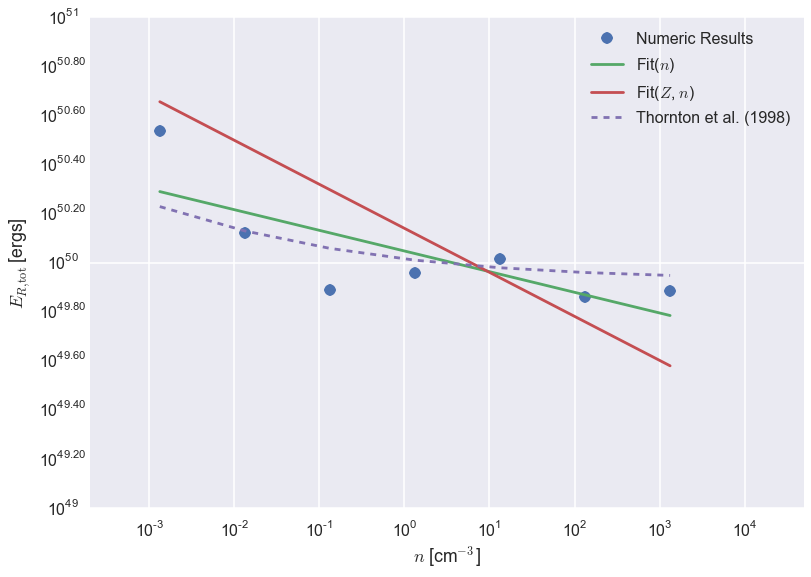

In [7]:
def plot_one_number_density(energy="tot"):
    mask = slice_by_metallicity

    y_variable = "E_R_" + energy

    number_density_models[energy].print_model()

    plt.figure()
    plt.plot(df.number_density[mask], df[y_variable][mask],
             marker="o", linestyle="",
             label=my_label)
    plt.plot(df.number_density[mask],
             number_density_models[energy](df.number_density[mask]),
             label=number_density_fit_label)
    plt.plot(df.number_density[mask],
             simultaneous_models[energy](df.metallicity[mask],
                                         df.number_density[mask]),
             label=simultaneous_fit_label)
    plt.plot(df.number_density[mask],
             thornton_models[energy](df.metallicity[mask],
                            df.number_density[mask]),
             label=Thornton_label, linestyle="--")
    plt.legend(loc="best")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$n$ [cm$^{-3}$]")
    plt.ylabel(r"$E_{{R, \mathrm{{ {0} }} }}$ [ergs]".format(energy))

    xmin, xmax = plt.xlim()
    plt.xlim(xmin/5, xmax*5)

    ax = plt.gca()
    ax.yaxis.set_minor_formatter(formatter)
    ax.yaxis.set_minor_locator(locator)
    plt.show() # until ipywidgets stops printing out None

    
# for energy in energies:
#     plot_one_number_density(energy=energy)
    
        
interactive(plot_one_number_density,
            energy = RadioButtons(options=energies))


<IPython.core.display.Math object>

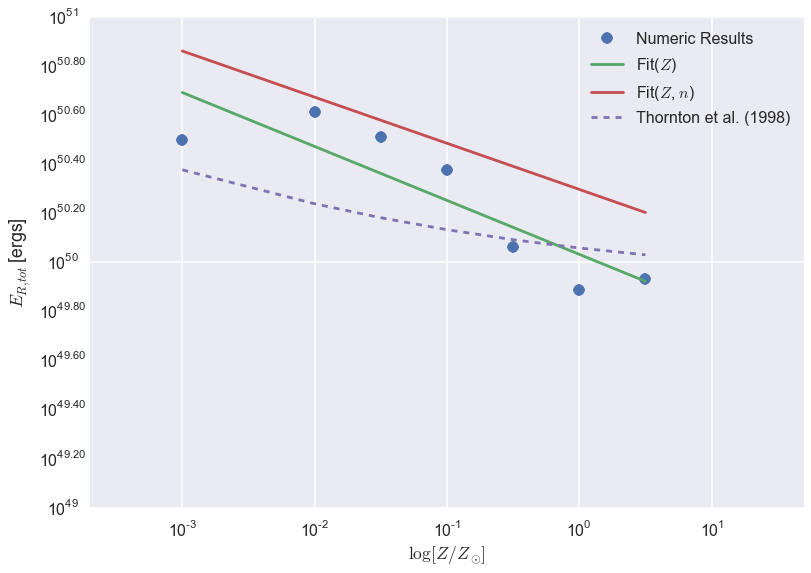

In [8]:
def plot_one_metallicity(energy="tot"):
    mask = slice_by_number_density

    y_variable = "E_R_" + energy
    
    metallicity_models[energy].print_model()
    
    plt.figure()
    plt.plot(df.metallicity[mask] / metallicity_solar,
             df[y_variable][mask],
             marker="o", linestyle="", label="Numeric Results")
    plt.plot(df.metallicity[mask] / metallicity_solar,
             metallicity_models[energy](df.metallicity[mask]),
             label=metallicity_fit_label)
    plt.plot(df.metallicity[mask] / metallicity_solar,
             simultaneous_models[energy](df.metallicity[mask],
                                         df.number_density[mask]),
             label=simultaneous_fit_label)
    plt.plot(df.metallicity[mask] / metallicity_solar,
             thornton_models[energy](df.metallicity[mask],
                            df.number_density[mask]),
             label=Thornton_label, linestyle="--")
    plt.legend(loc="best")
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel(r"$\log[Z / Z_\odot]$")
    plt.ylabel(r"$E_{{R, {0} }}$ [ergs]".format(energy))

    xmin, xmax = plt.xlim()
    plt.xlim(xmin/5, xmax*5)
    
    ax = plt.gca()
    ax.yaxis.set_minor_formatter(formatter)
    ax.yaxis.set_minor_locator(locator)

    
# for energy in energies:
#     plot_one_metallicity(energy = energy)
    
interactive(plot_one_metallicity,
            energy = RadioButtons(options=energies))
